# 3. Обробка та класифікація текстових даних

In [1]:
import pandas as pd
import numpy as np
import string

In [2]:
reviews = pd.read_csv('./spotify_app_reviews_dataset.csv', encoding='utf8')
print(reviews.head(20))
print(reviews.info())

                                               Review     label
0   Great music service, the audio is high quality...  POSITIVE
1   Please ignore previous negative rating. This a...  POSITIVE
2   This pop-up "Get the best Spotify experience o...  NEGATIVE
3     Really buggy and terrible to use as of recently  NEGATIVE
4   Dear Spotify why do I get songs that I didn't ...  NEGATIVE
5   The player controls sometimes disappear for no...  NEGATIVE
6   I love the selection and the lyrics are provid...  POSITIVE
7   Still extremely slow when changing storage to ...  NEGATIVE
8   It's a great app and the best mp3 music app I ...  POSITIVE
9   I'm deleting this app, for the following reaso...  NEGATIVE
10                    Can't play Spotify when on WiFi  NEGATIVE
11  I had amazon premium music family package and ...  NEGATIVE
12  Worst app always says I'm offline and never sh...  NEGATIVE
13        i hav any music that i like it is superðŸ™Œ  POSITIVE
14  Improve the IA to recommend songs an

In [3]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [4]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stopWords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FeelVR\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\FeelVR\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FeelVR\AppData\Roaming\nltk_data...


### Preprocessing and cleaning

In [5]:
spotifyStopWords = ['app', 'spotify', 'song', 'music', 'playlist', 'podcast', 'wa', 'good', 'great']

stopWords.update(spotifyStopWords)

In [6]:
lemmatizer = WordNetLemmatizer()

In [8]:
reviews['Review'] = reviews['Review'].astype(str).apply(lambda r: r.lower())
# remove punctuation
reviews['Review'] = reviews['Review'].apply(lambda r: r.translate(str.maketrans('', '', string.punctuation)))
# remove stop words
reviews['Review'] = reviews['Review'].apply(lambda r: str.join(' ', [lemmatizer.lemmatize(word) for word in word_tokenize(r) if lemmatizer.lemmatize(word) not in stopWords]))


In [9]:
# remove noise like ðŸ™Œ
import re
reviews['Review'] = reviews['Review'].apply(lambda r: re.sub('[^A-Za-z0-9 ]+', '', r))

In [10]:
reviews['Review'].head(20)

0     service audio high quality easy use also quick...
1     please ignore previous negative rating super g...
2     popup get best experience android 12 annoying ...
3                    really buggy terrible use recently
4                       dear get didnt put shuffle play
5     player control sometimes disappear reason rest...
6         love selection lyric provided youre listening
7     still extremely slow changing storage external...
8     best mp3 ever used one problem cant play find ...
9     im deleting following reason ha failing busine...
10                                       cant play wifi
11    amazon premium family package everyone could l...
12             worst always say im offline never showed
13                                       hav like super
14    improve ia recommend find similar itll best yo...
15    android user load glitch player bar disappears...
16    cant listen downloaded im offline whats point ...
17    always crashing unable play stop working e

### Wordcloud

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

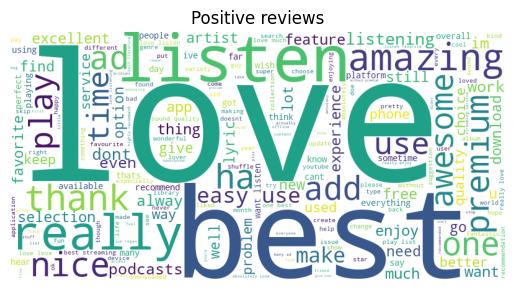

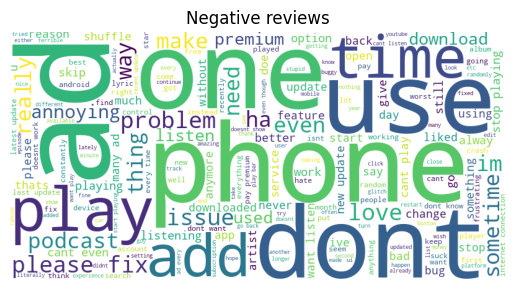

In [13]:
def visualizeWordCloud(label, title):
    text = str.join(' ', reviews[reviews['label'] == label]['Review'])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

visualizeWordCloud('POSITIVE', 'Positive reviews')
visualizeWordCloud('NEGATIVE', 'Negative reviews')


### Vectorization

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.model_selection import train_test_split

In [15]:

X_train, X_test, y_train, y_test = train_test_split(reviews['Review'], reviews['label'], test_size=0.20)
print(X_train.shape, y_train.shape)

(42161,) (42161,)


In [16]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_transformed = tfidf.fit_transform(X_train)
X_test_transformed = tfidf.transform(X_test)

In [17]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Classifier: Naive Bayes
[[5273  624]
 [1016 3628]]
              precision    recall  f1-score   support

    NEGATIVE       0.84      0.89      0.87      5897
    POSITIVE       0.85      0.78      0.82      4644

    accuracy                           0.84     10541
   macro avg       0.85      0.84      0.84     10541
weighted avg       0.84      0.84      0.84     10541

------------------------------------------------------------
Classifier: Logistic Regression
[[5305  592]
 [ 709 3935]]
              precision    recall  f1-score   support

    NEGATIVE       0.88      0.90      0.89      5897
    POSITIVE       0.87      0.85      0.86      4644

    accuracy                           0.88     10541
   macro avg       0.88      0.87      0.87     10541
weighted avg       0.88      0.88      0.88     10541

------------------------------------------------------------
Classifier: Linear SVC
[[5309  588]
 [ 701 3943]]
              precision    recall  f1-score   support

    NEGAT

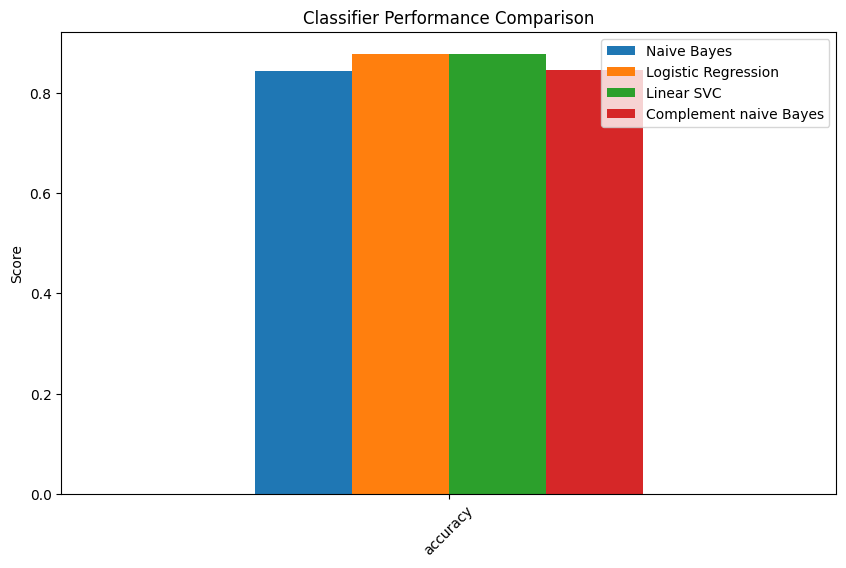

In [19]:
classifiers = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Linear SVC': LinearSVC(C=0.1, dual=False, max_iter=1000),
    'Complement naive Bayes': ComplementNB(alpha=0.1)
}

performance = {}

for name, clf in classifiers.items():
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)
    
    accuracy = accuracy_score(y_test, y_pred)
    performance[name] = {'accuracy': accuracy}
    
    print(f"Classifier: {name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('-' * 60)

performance_df = pd.DataFrame(performance)


performance_df.plot(kind='bar', figsize=(10, 6))
plt.title('Classifier Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()